# Exploratory Data Analysis (EDA)

All the X-ray images are stored in the 'COVID', 'Lung_Opacity', 'Viral Pneumonia', and 'Normal' directories, correspond to their X-ray images of their class. 

First we carry out the Exploratory Discovery Analysis (EDA) for our dataset. 

In [2]:
# Lung types with their corresponding directories
lungTypes = [
    'COVID', 
    'Lung_Opacity', 
    'Viral Pneumonia',
    'Normal'
]

In [3]:
import cv2

# example image in each class
img1 = 'Images/COVID/COVID-1.png'
img2 = 'Images/Lung_Opacity/Lung_Opacity-1.png'
img3 = 'Images/Viral Pneumonia/Viral Pneumonia-1.png'
img4 = 'Images/Normal/Normal-1.png'
sample_images_png = [img1, img2, img3, img4]

# convert the images into numpy array, read in grayscale
sample_images_read = [cv2.imread(img, 0) for img in sample_images_png]

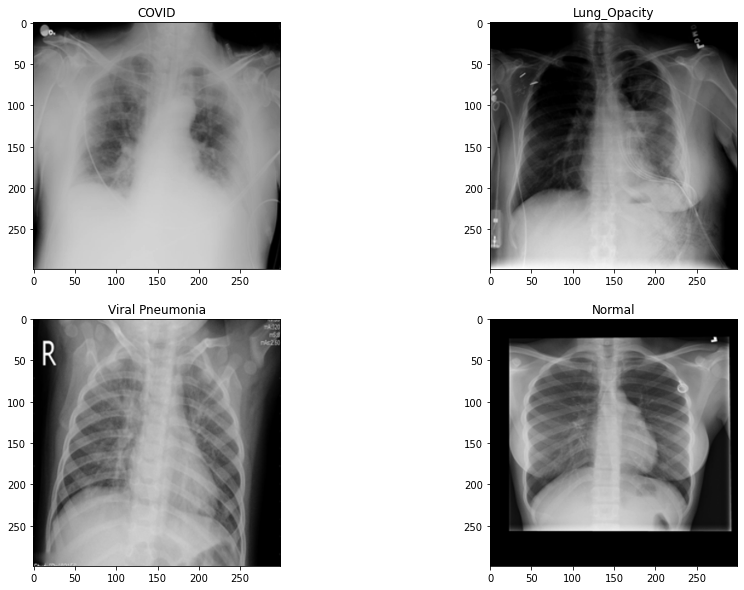

In [4]:
# Readimg example lung X-ray image from Covid, Lung Opacity, Viral Penumonia, and Normal patient
import matplotlib.pyplot as plt
import numpy as np

# 2*2 subplots 
fig, ax = plt.subplots(2, 2, figsize=(15, 10)) 

n = 0
for row in ax:
    for img in row:
        img.imshow(sample_images_read[n], 'gray') #show individual image
        img.set_title(lungTypes[n]) # set title for image
        n += 1

We can see there are similarities and differences between different lung types

In [5]:
# The original pixel of the image is 299 * 299
sample_images_read[0].shape

(299, 299)

# Machine Learning

## Preprocessing

In [6]:
from pathlib import Path

#empty lists
labels = [] 
image_samples = []

path = Path()
for lungtype in lungTypes: 
    img_dir = path / 'Images' / lungtype # image directory
    for img in img_dir.iterdir(): # read each image in the image directory
        data = cv2.imread(str(img), 0).reshape(1, -1) # convert the 2D 299*299 to 1 dimension array of 89401
        image_samples.append(data) # append the images to list
        labels.append(lungtype) # append the class labels to list

In [7]:
# covert the list to numpy array
image_samples = np.concatenate(image_samples)
labels = np.array(labels)

print(f"Final shape of samples: {image_samples.shape}")

Final shape of samples: (21165, 89401)


In [8]:
# there are total of 21165 samples of 299 * 299 pixels image in the samples
print(f"No of image samples: {len(image_samples)}")

No of image samples: 21165


## Binary classification

As our objective is only to perform binary classification between "COVID" class and "Others" (Non-covid) class, the non-covid labels are preprocessed.

In [11]:
# use certain samples only
np.random.seed(10)
choices = np.random.randint(len(labels), size=4000)

X = image_samples[choices]
y = labels[choices]

In [12]:
def convert_binaryclass(x):
    if x == 'COVID':
        return 1
    else:
        return 0
y_binary = np.array(list(map(convert_binaryclass, y)))

In [13]:
# example of y_binary
y_binary

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
# Test traing split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_binary,
                                                    test_size=0.3,
                                                    random_state=10,
                                                   stratify=y_binary)

In [15]:
# The y_labels distribution after the preprocessing
import pandas as pd

distribution = pd.DataFrame(y_train).value_counts(normalize=True)
distribution

0    0.830357
1    0.169643
dtype: float64

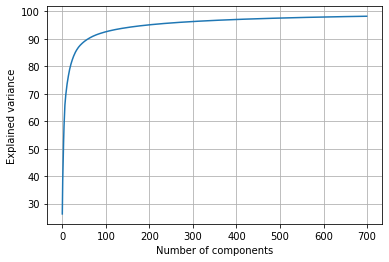

In [17]:
import numpy as np
from sklearn.decomposition import PCA

pca_700 = PCA(n_components=700)
pca_700.fit(X)

plt.grid()
plt.plot(np.cumsum(pca_700.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [19]:
explained = np.cumsum(pca_700.explained_variance_ratio_ * 100)
np.min(np.where(explained > 90))

60

## Transformation Pipeline

In [20]:
# model pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA, TruncatedSVD
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()), #standard scaling
    ('pca', IncrementalPCA(n_components=60, batch_size=100, copy=False)), # PCA Dimensionality reduction
                    ])

In [21]:
pipeline.fit(X_train)
X_train = pipeline.transform(X_train)

In [22]:
X_train.shape

(2800, 60)

## Model Training

### Random Forest

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train) #prediciton based on X_train

In [20]:
def score_check(ytrue, ypred, name):
    print(f"============= {name} Set Score ==========")
    print("Accuracy:", accuracy_score(ytrue, ypred))
    print("Precision:", precision_score(ytrue, ypred, pos_label=1))
    print("Recall:", recall_score(ytrue, ypred, pos_label=1))
    print("F1 Score:", f1_score(ytrue, ypred, pos_label=1))

In [21]:
score_check(y_train, y_train_pred, 'Training')

============= Training Set Score ==========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [22]:
# for stratified cross validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

In [23]:
# Collections of all the cross validation scores
final_scores = {}

In [24]:
from sklearn.model_selection import cross_val_score

def cv_score_check(model, X, y, cv, model_name=None, scores_dict=None, use=False):
    scores = {}
    cross_val_accuracy = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    cross_val_precision = cross_val_score(model, X, y, cv=cv, scoring="precision")
    cross_val_recall = cross_val_score(model, X, y, cv=cv, scoring="recall")
    cross_val_f1 = cross_val_score(model, X, y, cv=cv, scoring="f1")

    print("Accuracy:", cross_val_accuracy.mean())
    print("Precision:", cross_val_precision.mean())
    print("Recall:", cross_val_recall.mean())
    print("F1 Score:", cross_val_f1.mean())
    
    if use: #for recording the scores
        scores['Accuracy'] = cross_val_accuracy.mean()
        scores['Precision'] = cross_val_precision.mean()
        scores['Recall'] = cross_val_recall.mean()
        scores['F1_Score'] = cross_val_f1.mean()
        scores_dict[model_name] = scores

In [25]:
cv_score_check(forest, X_train, y_train, kf)

Accuracy: 0.8553578710047103
Precision: 0.8955273520647085
Recall: 0.1810100045113181
F1 Score: 0.2885528722971852


The model appears to be overfitting when using training set.
When using cross validation set, scoring slightly reduced.

#### Fine tuning hyperparameters

In [26]:
# Define hyperparameters to be used in the randomized search cross validation 

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num=10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 15, 21, 26, 32, 37, 43, 48, 54, 60, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [27]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=forest,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=kf,
                               verbose=2,
                               random_state=10,
                               n_jobs = -1,
                               scoring='f1')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 21, 26, 32, 37,
                                                      43, 48, 54, 60, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=10, scoring='f1', verbose=2)

In [28]:
# best model of the random forest model
forest_best = rf_random.best_estimator_
print(forest_best)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10)


In [29]:
cv_score_check(forest_best, X_train, y_train, kf, model_name='Random Forest', 
               scores_dict=final_scores, use=True)

Accuracy: 0.852145497053475
Precision: 0.7630839002267574
Recall: 0.23583578802112357
F1 Score: 0.33366064129635414


The fine-tuned model perform slightly better than the original model

### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_train_pred = logistic.predict(X_train)

/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
score_check(y_train, y_train_pred, 'Training')

============= Training Set Score ==========
Accuracy: 0.8510714285714286
Precision: 0.6686046511627907
Recall: 0.24210526315789474
F1 Score: 0.3554868624420402


In [32]:
# CV score before fine-tuning
cv_score_check(logistic, X_train, y_train, kf)

/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Accuracy: 0.8335731712075205
Precision: 0.5283766353418095
Recall: 0.20209378234217024
F1 Score: 0.29191345750036685


In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=logistic, 
                           param_grid=grid,
                           n_jobs=-1,
                           cv=kf,
                           scoring='f1',
                           error_score=0)

logistic_grid = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (logistic_grid.best_score_, logistic_grid.best_params_))
means = logistic_grid.cv_results_['mean_test_score']
stds = logistic_grid.cv_results_['std_test_score']
params = logistic_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ckng/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best: 0.345501 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.297580 (0.014221) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.294421 (0.008962) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.297580 (0.014221) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.297580 (0.014221) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.294421 (0.008962) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.297580 (0.014221) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.297580 (0.014221) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.291913 (0.008193) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.297580 (0.014221) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.297580 (0.014221) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.300153 (0.014681) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.294353 (0.001448) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.297580 (0.014221) wi

In [34]:
logistic_best = logistic_grid.best_estimator_
print(logistic_best)

LogisticRegression(C=0.01, solver='liblinear')


In [35]:
# CV score after fine-tuning
cv_score_check(logistic_best, X_train, y_train, kf, model_name='Logistic Regression', 
               scores_dict=final_scores, use=True)

Accuracy: 0.8307153900941985
Precision: 0.5042123098007191
Recall: 0.2631690682801263
F1 Score: 0.3455012967683533


### SVM

In [36]:
# SVM
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
score_check(y_train, y_train_pred, 'Training')

============= Training Set Score ==========
Accuracy: 0.9303571428571429
Precision: 0.9605263157894737
Recall: 0.6147368421052631
F1 Score: 0.7496790757381258


In [37]:
# CV score before fine-tuning
cv_score_check(svm, X_train, y_train, kf)

Accuracy: 0.8746435902084944
Precision: 0.8515172663358147
Recall: 0.3178887031287318
F1 Score: 0.46221166221166216


In [38]:
# # SVM
from sklearn.svm import SVC

param_grid = {'C':[0.1,1, 10, 100],'gamma':[0.0001,0.001,'scale'],'kernel':['rbf']}
svc = SVC(probability=True)
svm_grid = GridSearchCV(svc, param_grid, scoring='f1', cv=kf)
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 'scale'], 'kernel': ['rbf']},
             scoring='f1')

In [39]:
svm_best = svm_grid.best_estimator_
print(svm_best)

SVC(C=10, probability=True)


In [40]:
# CV score after fine-tuning
cv_score_check(svm_best, X_train, y_train, kf, model_name='SVM', 
               scores_dict=final_scores, use=True)

Accuracy: 0.9028595406894325
Precision: 0.7603786980251485
Recall: 0.6275110792665127
F1 Score: 0.6857164984852281


## Cross Validation Results Compare

In [41]:
result = pd.DataFrame(final_scores)
result

,Random Forest,Logistic Regression,SVM
Accuracy,0.852145,0.830715,0.902860
Precision,0.763084,0.504212,0.760379
Recall,0.235836,0.263169,0.627511
F1_Score,0.333661,0.345501,0.685716


We can see that SVM has the best accuracy, precision, recall, and F1 score in the cross validation set

# ROC Curve

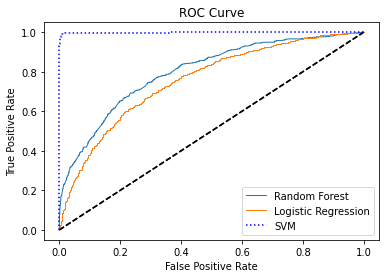

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Random Forest
y_probas_forest = cross_val_predict(forest_best, X_train, y_train, cv=kf, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

# Logistic Regression
y_probas_logistic = cross_val_predict(logistic_best, X_train, y_train, cv=kf, method="predict_proba")
y_scores_logistic = y_probas_logistic[:, 1] # score = proba of positive class
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_train, y_scores_logistic)

# SVM
y_scores_svm = svm_best.decision_function(X_train)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)


def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") # Random Forest Plot
plot_roc_curve(fpr_logistic, tpr_logistic, "Logistic Regression") # Random Forest Plot
plt.plot(fpr_svm, tpr_svm, "b:", label="SVM") #SVM Plot
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## ROC Scores

In [44]:
# Random Forest
roc_auc_forest = roc_auc_score(y_train, y_scores_forest)

# Logistic Regression
roc_auc_logistic = roc_auc_score(y_train, y_scores_logistic)

# SVM
roc_auc_svm = roc_auc_score(y_train, y_scores_svm)

print(f"Random Forest ROC AUC: {roc_auc_forest}")
print(f"Logistic Regression ROC AUC: {roc_auc_logistic}")
print(f"SVM ROC AUC: {roc_auc_svm}")

Random Forest ROC AUC: 0.7993435200905489
Logistic Regression ROC AUC: 0.7580251273344654
SVM ROC AUC: 0.99892246745897


## Test

In [45]:
X_test = pipeline.transform(X_test)

In [46]:
# Random Forest
y_test_pred = forest_best.predict(X_test)
score_check(y_test, y_test_pred, 'Test')

============= Test Set Score ==========
Accuracy: 0.875
Precision: 0.9344262295081968
Recall: 0.28078817733990147
F1 Score: 0.43181818181818177


In [47]:
# Logistic regression
y_test_pred = logistic_best.predict(X_test)
score_check(y_test, y_test_pred, 'Test')

============= Test Set Score ==========
Accuracy: 0.8491666666666666
Precision: 0.6617647058823529
Recall: 0.22167487684729065
F1 Score: 0.3321033210332104


In [48]:
# SVM
y_test_pred = svm_best.predict(X_test)
score_check(y_test, y_test_pred, 'Test')

============= Test Set Score ==========
Accuracy: 0.9225
Precision: 0.8395061728395061
Recall: 0.6699507389162561
F1 Score: 0.7452054794520548


We observed SVM model has the best performacne.
Using the best model, SVM, we further explore it

## Confusion Matrix

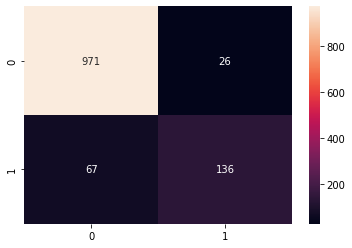

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;

cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='.3g');

We can see the true negative (971) and true positive (136) are relatively high compared to the false positive (26) and false negative (67). 